In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.utils import resample
import matplotlib.pyplot as plt

Original Class Distribution:
flare_class_encoded
200    7560
300    3440
400     440
Name: count, dtype: int64
Overall Mean Accuracy: 0.7233010752688173
Overall Mean ROC AUC: 0.8633478259119741
Overall Mean PR AUC: 0.8098588031248607


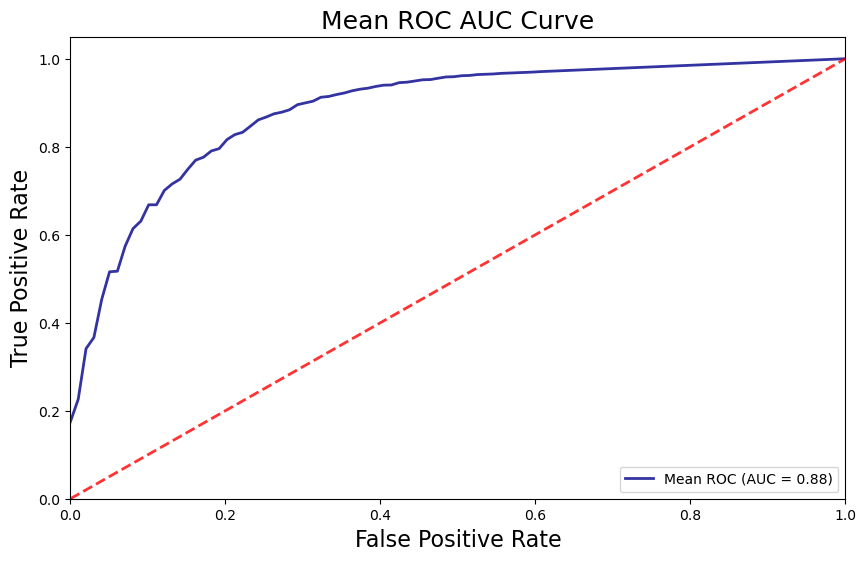

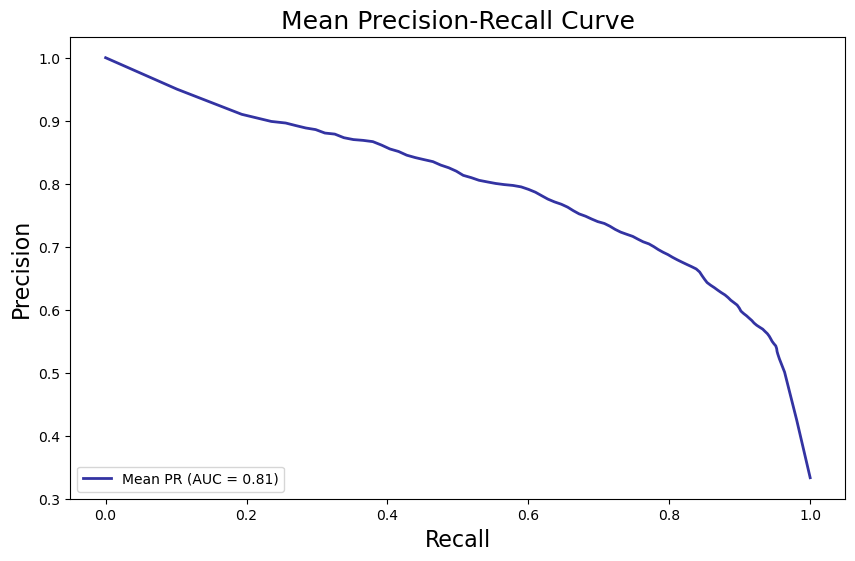

Final Training Set Class Distribution:
flare_class_encoded
200    142
300    142
400     23
Name: count, dtype: int64


In [2]:
#MULTICLASS CLASSIFICATION - 7PC
from sklearn.preprocessing import label_binarize
# Load your dataset
df = pd.read_csv("7_pc.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

def create_multiclass_splits(n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            c_class_samples = resample(df[df['flare_class_encoded'].between(200, 299)],
                                       replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['flare_class_encoded'].between(300, 399)],
                                       replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['flare_class_encoded'].between(400, 499)],
                                       replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded']) # feature variables
            y = complete_data['flare_class_encoded']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multi-class classification with 10-fold cross-validation
multiclass_splits = create_multiclass_splits()
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in multiclass_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy = np.mean(mean_acc_list)
    overall_mean_roc_auc = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_7PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_7PC}")

    # combined Plot Mean ROC AUC Curve (7;100 PC)
    mean_fpr_7PC = np.linspace(0, 1, 100)
    mean_tpr_7PC = np.mean([np.interp(mean_fpr_7PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_7PC[-1] = 1.0
    mean_roc_auc_7PC = auc(mean_fpr_7PC, mean_tpr_7PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_7PC, mean_tpr_7PC, color='darkblue', label=f'Mean ROC (AUC = {mean_roc_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC AUC curve - KNN multiclass 7 PC.png")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_7PC = np.zeros_like(mean_fpr_7PC)
    for precision, length in all_precision:
        mean_precision_7PC += np.interp(mean_fpr_7PC, np.linspace(0, 1, length), precision)
    mean_precision_7PC /= len(all_precision)

    mean_recall_7PC = np.mean([np.interp(mean_fpr_7PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

    # Plot Mean precision recall Curve (7 PC)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_7PC, mean_precision_7PC, color='darkblue', label=f'Mean PR (AUC = {overall_mean_pr_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR curve - KNN multiclass 7PC.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")



Original Class Distribution:
flare_class_encoded
200    7560
300    3440
400     440
Name: count, dtype: int64
Overall Mean Accuracy: 0.7457419354838709
Overall Mean ROC AUC: 0.8713881704980843
Overall Mean PR AUC: 0.8207231621592801


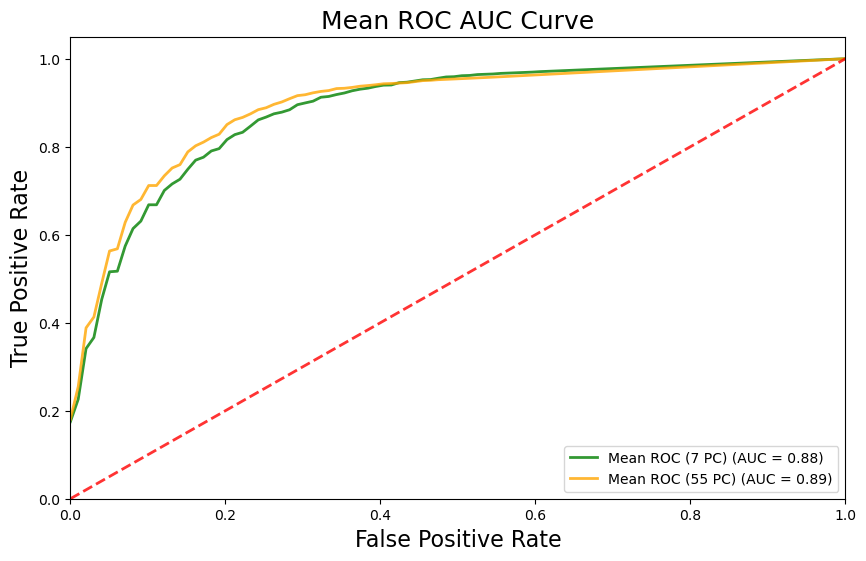

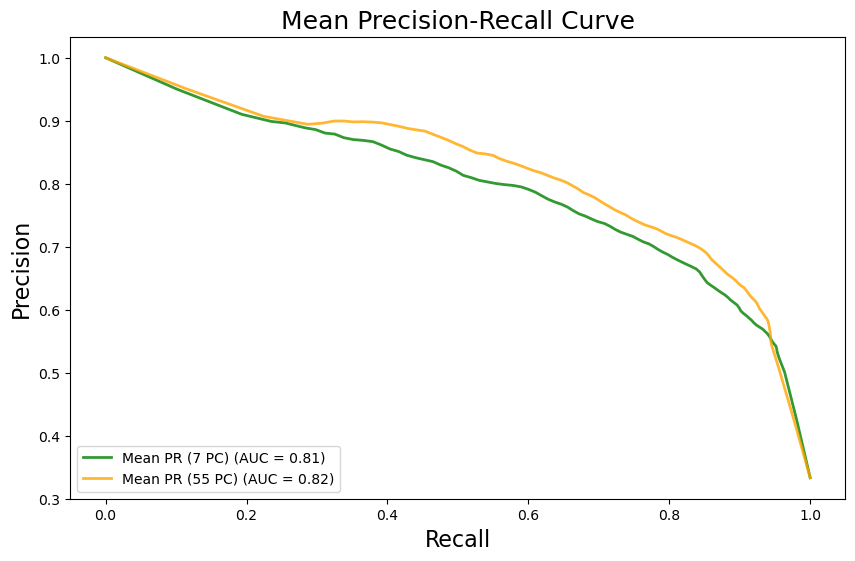

Final Training Set Class Distribution:
flare_class_encoded
200    142
300    142
400     23
Name: count, dtype: int64


Exception ignored in: <function ResourceTracker.__del__ at 0x10881dda0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1071d5da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1050f9da0>
Traceback (most recent call last

In [ ]:
#MULTICLASS - 55 PC

# Load your dataset
df = pd.read_csv("55_pc.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

def create_multiclass_splits(n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            c_class_samples = resample(df[df['flare_class_encoded'].between(200, 299)],
                                       replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['flare_class_encoded'].between(300, 399)],
                                       replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['flare_class_encoded'].between(400, 499)],
                                       replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded'])
            y = complete_data['flare_class_encoded']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multi-class classification with 10-fold cross-validation
multiclass_splits = create_multiclass_splits()
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in multiclass_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy_55PC = np.mean(mean_acc_list)
    overall_mean_roc_auc_55PC = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_55PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy_55PC}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc_55PC}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_55PC}")


  # combined Plot Mean ROC AUC Curve (8;100 PC)
    mean_fpr_55PC = np.linspace(0, 1, 100)
    mean_tpr_55PC = np.mean([np.interp(mean_fpr_55PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_55PC[-1] = 1.0
    mean_roc_auc_55PC = auc(mean_fpr_55PC, mean_tpr_55PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_7PC, mean_tpr_7PC, color='green', label=f'Mean ROC (7 PC) (AUC = {mean_roc_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_55PC, mean_tpr_55PC, color='orange', label=f'Mean ROC (55 PC) (AUC = {mean_roc_auc_55PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC AUC curve - KNN MULTICLASS 7;55 PC.png")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_55PC = np.zeros_like(mean_fpr_55PC)
    for precision, length in all_precision:
        mean_precision_55PC += np.interp(mean_fpr_55PC, np.linspace(0, 1, length), precision)
    mean_precision_55PC /= len(all_precision)

    mean_recall_55PC = np.mean([np.interp(mean_fpr_55PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

     # combined Plot Mean Precison-Recall Curve (7;55 PC)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_7PC, mean_precision_7PC, color='green', label=f'Mean PR (7 PC) (AUC = {overall_mean_pr_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_55PC, mean_precision_55PC, color='orange', label=f'Mean PR (55 PC) (AUC = {overall_mean_pr_auc_55PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR curve - KNN MULTICLASS 7;55 PC.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")



In [3]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --- Replace these with your actual variables ---
# y_test = true labels
# y_pred = model predictions
# Example:
# y_pred = best_model_knn.predict(X_test)
# -----------------------------------------------

# Compute F1 Scores
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("F1 Score (Weighted):", round(f1_weighted, 4))
print("F1 Score (Macro):", round(f1_macro, 4))
print("F1 Score (Micro):", round(f1_micro, 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'y_test' is not defined

Original Class Distribution:
flare_class_encoded
200    7560
300    3440
400     440
Name: count, dtype: int64

Confusion Matrix (Final Fold):
[[ 8  6  0]
 [ 1 12  1]
 [ 0  1  1]]


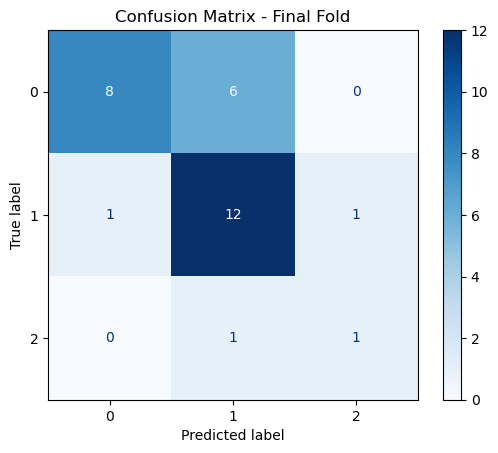


Confusion Matrix (Final Fold):
[[13  1  0]
 [ 5  9  0]
 [ 0  1  1]]


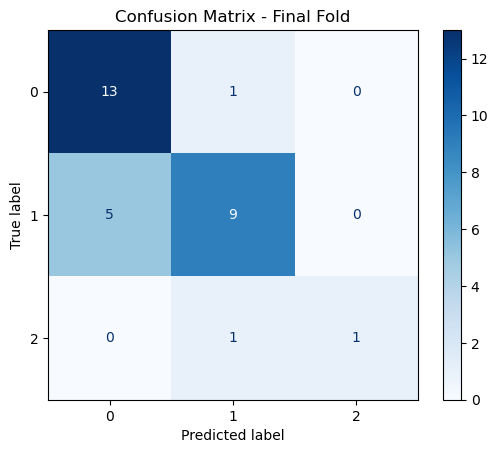


Confusion Matrix (Final Fold):
[[12  2  0]
 [ 3 11  0]
 [ 0  0  2]]


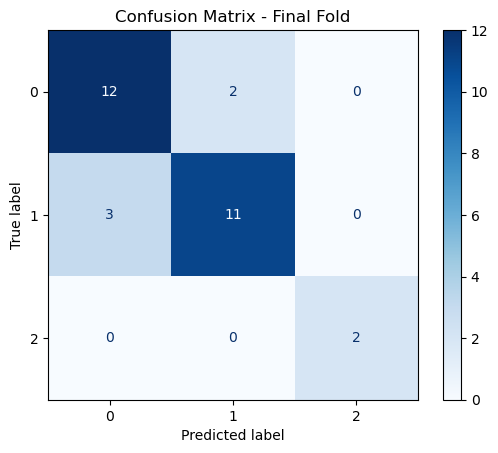


Confusion Matrix (Final Fold):
[[13  0  1]
 [ 7  7  0]
 [ 0  1  1]]


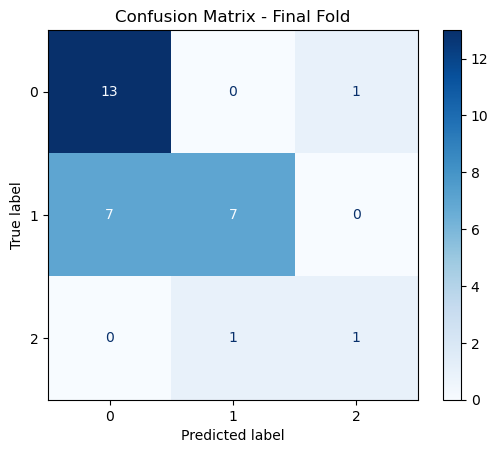


Confusion Matrix (Final Fold):
[[ 9  5  0]
 [ 0 14  0]
 [ 0  2  0]]


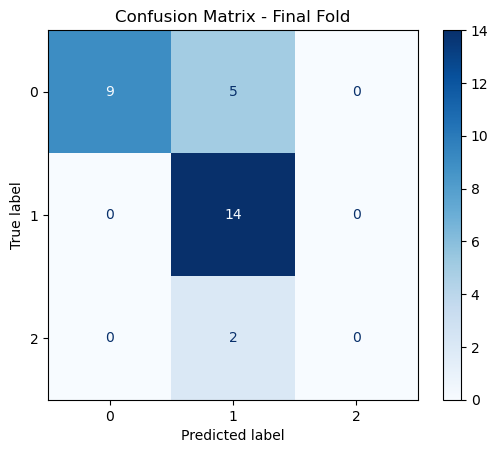


Confusion Matrix (Final Fold):
[[10  4  0]
 [ 5  9  0]
 [ 0  1  1]]


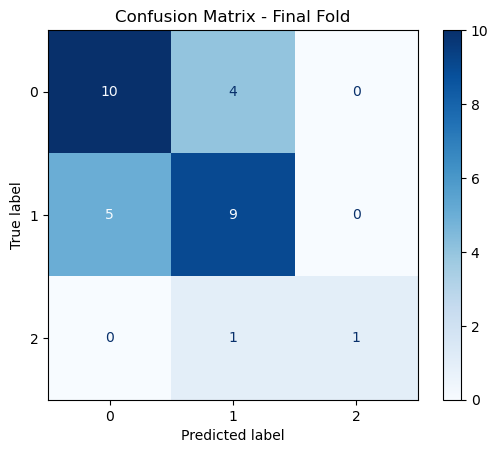


Confusion Matrix (Final Fold):
[[11  3  0]
 [ 4 10  0]
 [ 0  1  1]]


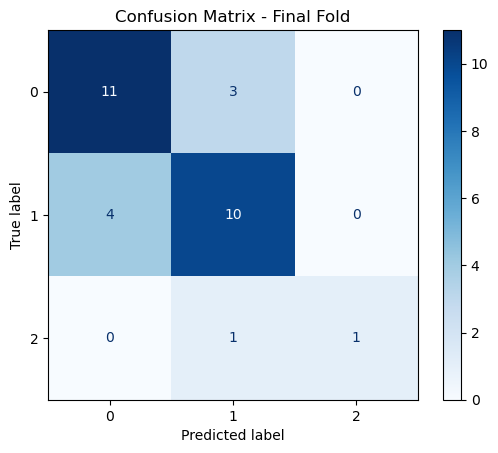


Confusion Matrix (Final Fold):
[[13  1  0]
 [ 7  7  0]
 [ 0  1  1]]


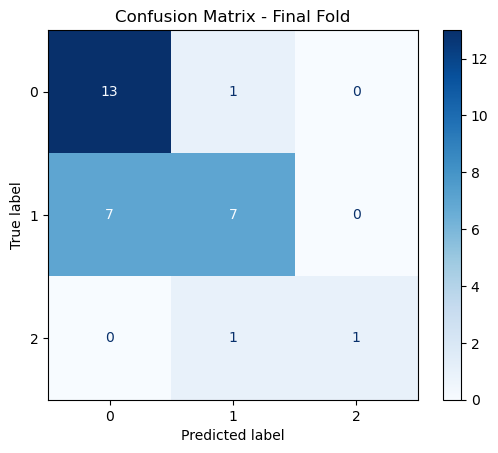


Confusion Matrix (Final Fold):
[[10  2  2]
 [ 6  8  0]
 [ 0  0  2]]


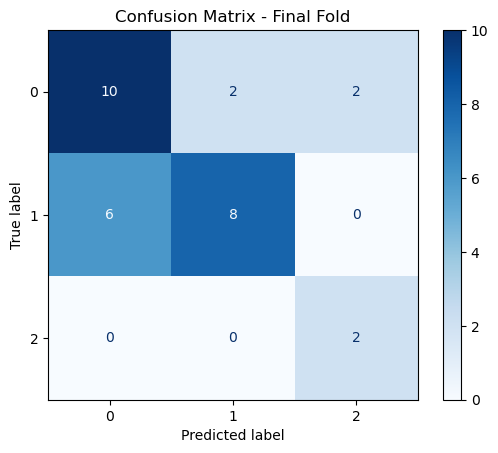


Confusion Matrix (Final Fold):
[[10  4  0]
 [ 1 11  2]
 [ 0  0  2]]


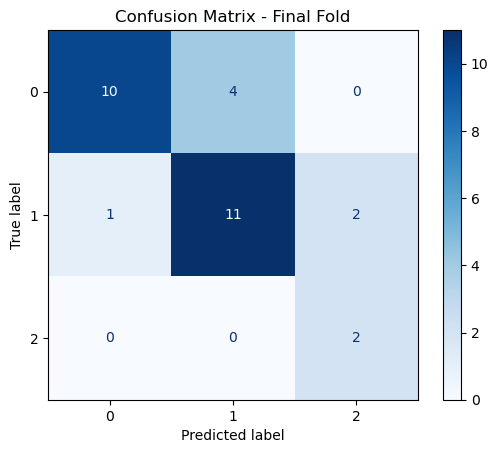


Overall Mean Accuracy: 0.7233
Overall Mean ROC AUC: 0.8633
Overall Mean PR AUC: 0.8099
Overall Mean F1 Score: 0.7179


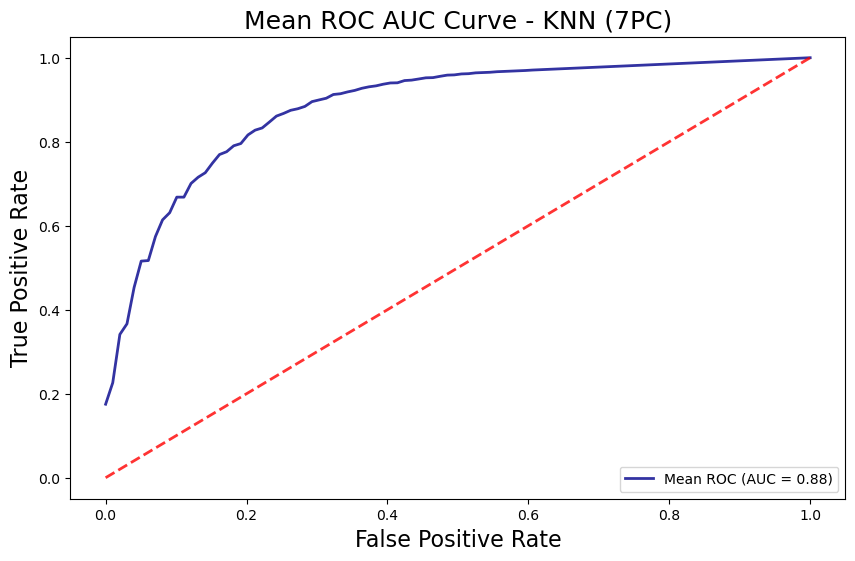

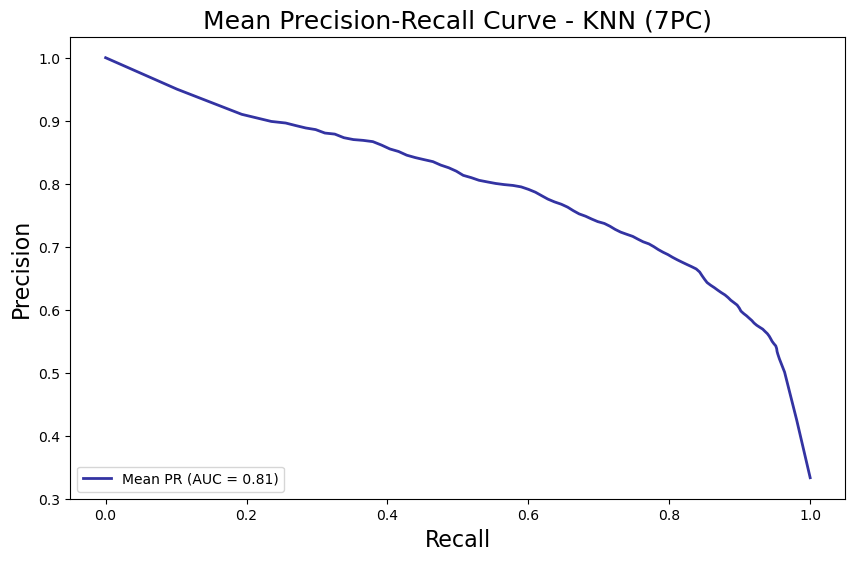


Final Training Set Class Distribution:
flare_class_encoded
200    142
300    142
400     23
Name: count, dtype: int64


In [ ]:
# MULTICLASS CLASSIFICATION - 7PC
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, auc,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("7_pc.csv")

# Check class distribution
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# -------------------------
# Create multiclass splits
# -------------------------
def create_multiclass_splits(n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            c_class_samples = resample(df[df['flare_class_encoded'].between(200, 299)],
                                       replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['flare_class_encoded'].between(300, 399)],
                                       replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['flare_class_encoded'].between(400, 499)],
                                       replace=False, n_samples=23, random_state=repeat)

            complete_data = pd.concat([c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded'])
            y = complete_data['flare_class_encoded']

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits


# -------------------------
# KNN evaluation function
# -------------------------
def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    best_params_list = []
    fpr_list, tpr_list, precision_list, recall_list = [], [], [], []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))

        # F1 score (weighted)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Confusion matrix (display only last fold)
        if fold == n_splits:
            cm = confusion_matrix(y_test, y_pred)
            print("\nConfusion Matrix (Final Fold):")
            print(cm)
            ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
            plt.title("Confusion Matrix - Final Fold")
            plt.show()

        # ROC & PR metrics
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return (
        np.mean(accuracy_scores),
        np.mean(roc_auc_scores),
        np.mean(pr_auc_scores),
        np.mean(f1_scores),
        best_params_list,
        accuracy_scores,
        roc_auc_scores,
        pr_auc_scores,
        f1_scores,
        fpr_list,
        tpr_list,
        precision_list,
        recall_list
    )


# -------------------------
# Run evaluation
# -------------------------
multiclass_splits = create_multiclass_splits()
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list, mean_roc_auc_list, mean_pr_auc_list, mean_f1_list = [], [], [], []
    best_params_list = []
    all_accuracy_scores, all_roc_auc_scores, all_pr_auc_scores, all_f1_scores = [], [], [], []
    all_fpr, all_tpr, all_precision, all_recall = [], [], [], []

    for X, y in multiclass_splits:
        (
            mean_acc, mean_roc_auc, mean_pr_auc, mean_f1,
            best_params, accuracy_scores, roc_auc_scores,
            pr_auc_scores, f1_scores, fpr_list, tpr_list,
            precision_list, recall_list
        ) = evaluate_model_with_knn(X, y)

        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        mean_f1_list.append(mean_f1)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_f1_scores.extend(f1_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    # -------------------------
    # Print overall metrics
    # -------------------------
    overall_mean_accuracy = np.mean(mean_acc_list)
    overall_mean_roc_auc = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_7PC = np.mean(mean_pr_auc_list)
    overall_mean_f1_7PC = np.mean(mean_f1_list)

    print(f"\nOverall Mean Accuracy: {overall_mean_accuracy:.4f}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc:.4f}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_7PC:.4f}")
    print(f"Overall Mean F1 Score: {overall_mean_f1_7PC:.4f}")

    # -------------------------
    # Plot Mean ROC Curve
    # -------------------------
    mean_fpr_7PC = np.linspace(0, 1, 100)
    mean_tpr_7PC = np.mean([np.interp(mean_fpr_7PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_7PC[-1] = 1.0
    mean_roc_auc_7PC = auc(mean_fpr_7PC, mean_tpr_7PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_7PC, mean_tpr_7PC, color='darkblue',
             label=f'Mean ROC (AUC = {mean_roc_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Mean ROC AUC Curve - KNN (7PC)', fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC_AUC_curve_KNN_multiclass_7PC.png")
    plt.show()

    # -------------------------
    # Plot Mean PR Curve
    # -------------------------
    mean_precision_7PC = np.zeros_like(mean_fpr_7PC)
    for precision, length in all_precision:
        mean_precision_7PC += np.interp(mean_fpr_7PC, np.linspace(0, 1, length), precision)
    mean_precision_7PC /= len(all_precision)

    mean_recall_7PC = np.mean(
        [np.interp(mean_fpr_7PC, np.linspace(0, 1, length), recall) for recall, length in all_recall],
        axis=0
    )

    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_7PC, mean_precision_7PC, color='darkblue',
             label=f'Mean PR (AUC = {overall_mean_pr_auc_7PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Mean Precision-Recall Curve - KNN (7PC)', fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR_curve_KNN_multiclass_7PC.png")
    plt.show()

# -------------------------
# Print sample final class distribution
# -------------------------
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"\nFinal Training Set Class Distribution:\n{y.value_counts()}")

In [4]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # F1 score (weighted average for multiclass)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Confusion matrix for the last fold (can adjust if you want average)
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix (one fold):")
        print(cm)
        ConfusionMatrixDisplay(cm).plot(cmap='Blues')

        # ROC & PR curves
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return (
        np.mean(accuracy_scores),
        np.mean(roc_auc_scores),
        np.mean(pr_auc_scores),
        np.mean(f1_scores),
        best_params_list,
        accuracy_scores,
        roc_auc_scores,
        pr_auc_scores,
        f1_scores,
        fpr_list,
        tpr_list,
        precision_list,
        recall_list
    )

overall_mean_f1_55PC = np.mean([np.mean(f1_scores) for f1_scores in all_pr_auc_scores])
print(f"Overall Mean F1 Score: {overall_mean_f1_55PC}")

print("\nConfusion Matrix (one fold):")
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

final_cm = cm  # overwrite each time, so only last one remains
...
# After loop ends
print("\nFinal Confusion Matrix:")
print(final_cm)
ConfusionMatrixDisplay(final_cm).plot(cmap='Blues')

Overall Mean F1 Score: 0.809858803124861

Confusion Matrix (one fold):


NameError: name 'cm' is not defined

/var/folders/fp/3mlnnsf909g5drpztf05fk780000gp/T/ipykernel_2569/843650905.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('flare_class_encoded', group_keys=False).apply(lambda x: resample(x, replace=False, n_samples=min(len(x), 50)))
/var/folders/fp/3mlnnsf909g5drpztf05fk780000gp/T/ipykernel_2569/843650905.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.gr

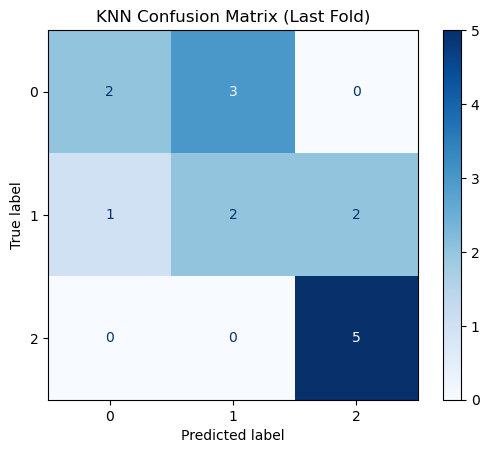

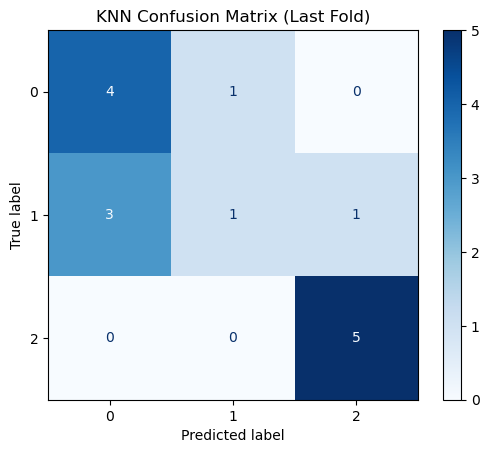

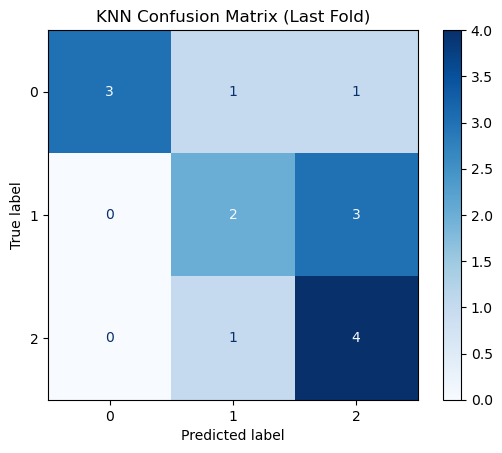

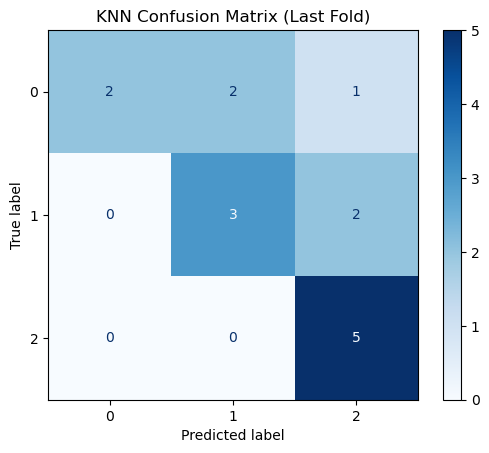

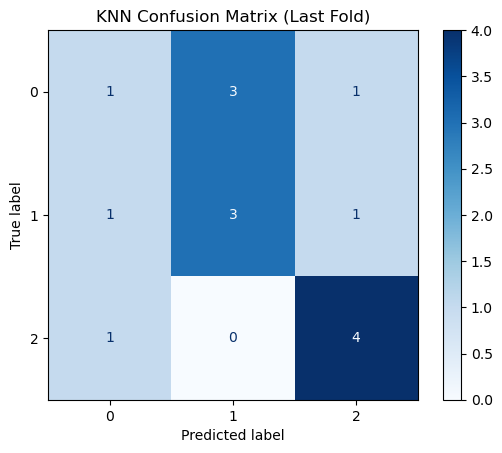


==== Final Evaluation Results (KNN - 55PC) ====
Overall Mean Accuracy : 0.7493
Overall Mean ROC AUC  : 0.8737
Overall Mean PR AUC   : 0.8056
Overall Mean F1 Score : 0.7376


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# =============================================
# FUNCTION: Evaluate KNN model with full metrics
# =============================================
def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define parameter grid for KNN
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    f1_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Binarize labels for multi-class ROC
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)

        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        # --- NEW: F1 score ---
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        # Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    # --- Plot confusion matrix for last fold ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("KNN Confusion Matrix (Last Fold)")
    plt.show()

    # Return all metrics
    return (
        np.mean(accuracy_scores),
        np.mean(roc_auc_scores),
        np.mean(pr_auc_scores),
        np.mean(f1_scores),
        best_params_list,
        accuracy_scores,
        roc_auc_scores,
        pr_auc_scores,
        f1_scores,
        fpr_list,
        tpr_list,
        precision_list,
        recall_list
    )

# =============================================
# EXAMPLE MULTICLASS SPLIT LOOP (55PC example)
# =============================================
# Replace this with your actual dataset and splits
def create_multiclass_splits(df, n_repeats=10):
    all_splits = []
    for _ in range(n_repeats):
        # Example: Stratified resampling per class
        from sklearn.utils import resample
        sampled_df = df.groupby('flare_class_encoded', group_keys=False).apply(lambda x: resample(x, replace=False, n_samples=min(len(x), 50)))
        X = sampled_df.drop(columns=['flare_class_encoded'])
        y = sampled_df['flare_class_encoded']
        all_splits.append((X, y))
    return all_splits

# Load your dataset
df = pd.read_csv("55_pc.csv")  # Replace with your dataset file
multiclass_splits = create_multiclass_splits(df, n_repeats=5)

# =============================================
# MAIN EVALUATION LOOP
# =============================================
mean_acc_list, mean_roc_auc_list, mean_pr_auc_list, mean_f1_list = [], [], [], []

for X, y in multiclass_splits:
    (mean_acc, mean_roc_auc, mean_pr_auc, mean_f1, best_params,
     accuracy_scores, roc_auc_scores, pr_auc_scores, f1_scores,
     fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)

    mean_acc_list.append(mean_acc)
    mean_roc_auc_list.append(mean_roc_auc)
    mean_pr_auc_list.append(mean_pr_auc)
    mean_f1_list.append(mean_f1)

# =============================================
# PRINT FINAL AVERAGE RESULTS
# =============================================
overall_mean_accuracy_55PC = np.mean(mean_acc_list)
overall_mean_roc_auc_55PC = np.mean(mean_roc_auc_list)
overall_mean_pr_auc_55PC = np.mean(mean_pr_auc_list)
overall_mean_f1_55PC = np.mean(mean_f1_list)

print(f"\n==== Final Evaluation Results (KNN - 55PC) ====")
print(f"Overall Mean Accuracy : {overall_mean_accuracy_55PC:.4f}")
print(f"Overall Mean ROC AUC  : {overall_mean_roc_auc_55PC:.4f}")
print(f"Overall Mean PR AUC   : {overall_mean_pr_auc_55PC:.4f}")
print(f"Overall Mean F1 Score : {overall_mean_f1_55PC:.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.close('all')       # Close all previous figures
plt.clf()              # Clear the current figure (if any)
plt.figure().clear()   # Force a fresh figure instance